# Merge sort

This implements a parallel merge sort using `DataFlowTasks`

## Sequential version

We'll use a "bottom-up" implementation of the merge sort algorithm. To explain
how it works, let's consider a small vector of 32 elements:

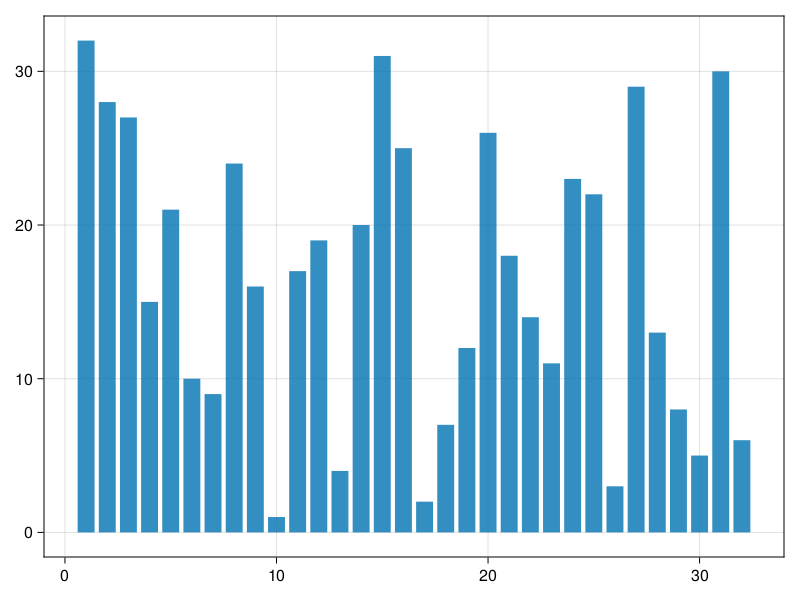

In [1]:
using Random, CairoMakie, CairoMakie.Colors
v = randperm(32)
barplot(v)

We decompose it into 4 blocks of 8 elements, which we sort individually:

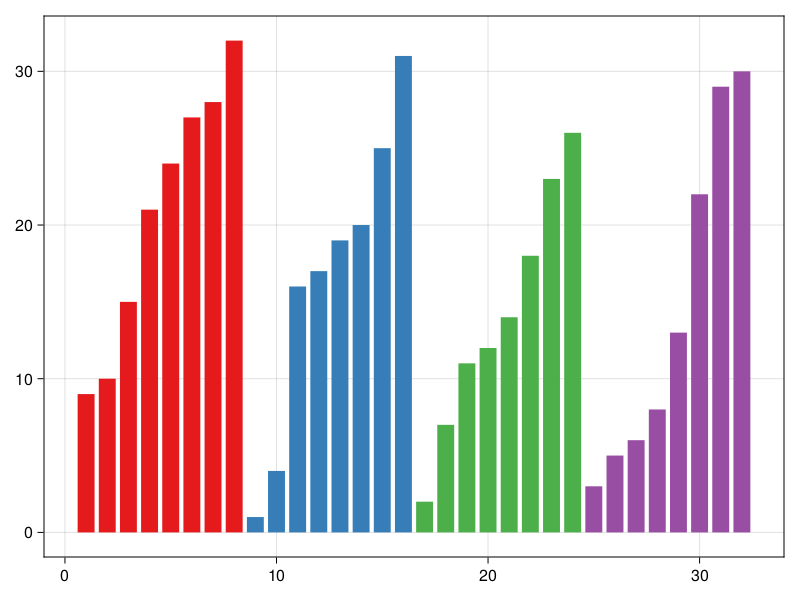

In [2]:
sort!(view(v, 1:8))
sort!(view(v, 9:16))
sort!(view(v, 17:24))
sort!(view(v, 25:32))
barplot(v; color=ceil.(Int, eachindex(v)./8), colormap=:Set1_4)

Now we can merge the first two 8-element blocks into a sorted 16-element
block. And do the same for the 3rd and 4th 8-element blocks. We'll need an
auxilliary array `w` to store the results:

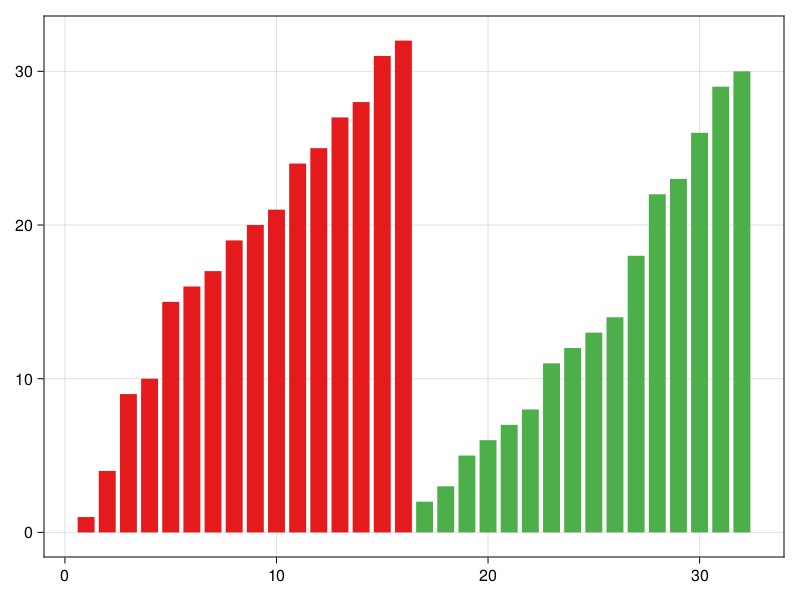

In [3]:
function merge!(dest, src, i0, i1, i2)
    # pre-condition:
    #   src[i₀:i₁-1] is sorted
    #   src[i₁:i₂]   is sorted
    # post-condition
    #   dest[i₀:i₂]  is sorted

    (i, j) = (i0, i1)
    @inbounds for k in i0:i2
        if i < i1 && (j > i2 || src[i] < src[j])
            dest[k] = src[i]; i+=1
        else
            dest[k] = src[j]; j+=1
        end
    end
end

w = similar(v)
merge!(w, v, 1, 9, 16)
merge!(w, v, 17, 25, 32)
barplot(w; color=ceil.(Int, eachindex(v)./16), colormap=:Set1_3)

Now `w` is sorted in two blocks, which we can merge to get the entire sorted
array. Instead of using a new buffer to store the results, let's re-use the
original array `v`:

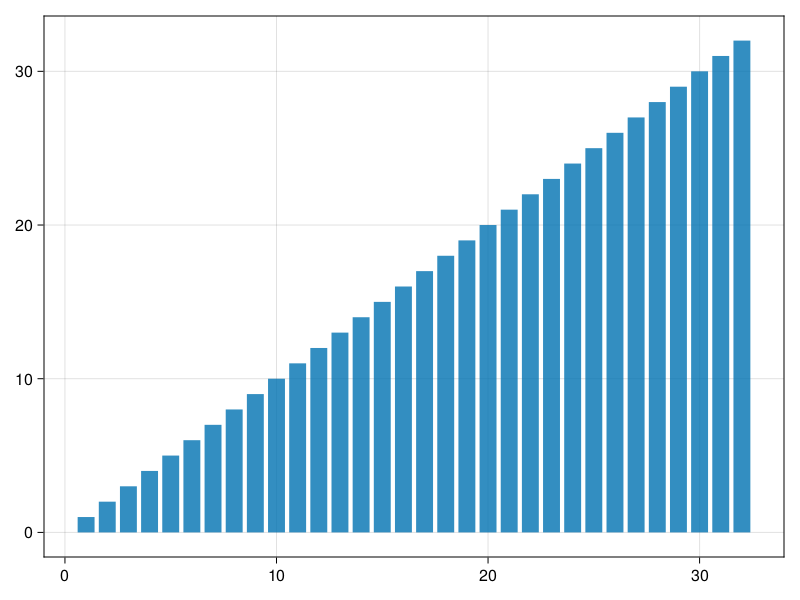

In [4]:
merge!(v, w, 1, 17, 32)
barplot(v)

The following sequential implementation automates these steps.

First, the vector is decomposed in blocks of size 64 (by default). Each block is
sorted using an insertion sort (which works in-place without allocating
anything, and is relatively fast for small vectors).

Then, sorted blocks are grouped in pairs which are merged into the buffer. If
the number of blocks is odd, the last block is copied directly to the
destination buffer.

The auxiliary buffer is now composed of sorted blocks twice as large as the
original blocks, so we can iterate the algorithm with a doubled block size,
this time putting the results back to the original vector.

Depending on the parity of the number of iterations, the final result ends up
being stored either in the original vector (which is what we want) or in the
auxiliary buffer (in which case we copy it back to the original vector). The
semantics of `mergesort!` is thus that of an in-place sort: after the call,
`v` should be sorted.

In [5]:
function mergesort!(v, buf=similar(v), bs=64)
    N = length(v)

    for i in 1:bs:N
        j = min(i+bs-1, N)
        sort!(view(v, i:j), alg=InsertionSort)
    end

    (a, b) = (v, buf)

    while bs < length(v)
        i = 1
        while i < N
            i1 = i+bs;    i1>N && break
            i2 = i+2bs-1; i2 = min(i2, N)
            merge!(b, a, i, i1, i2)

            i = i2+1
        end
        if i <= N
            @inbounds for k in i:N ; b[k] = a[k] ; end
        end

        bs *= 2
        (a, b) = (b, a)
    end

    v === a || copy!(v, a)
    v
end

N = 100_000
v = rand(N)
buf = similar(v)

@assert mergesort!(copy(v), buf) == sort(v)

## Parallel version

Parallelizing with DataFlowTasks involves splitting the work into several
parallel tasks, which have to be annotated to list their data dependencies. In our case:

- Sorting each initial block involves calling the sequential implementation on
  it. The block size is larger here, to avoid spawning tasks for too small
  chunks. Each such task modifies its own block in-place.

- Merging two blocks (or copying a lone block) reads part of the source array, and writes to (the same)
  part of the destination array.

- A final task reads the whole array to act as a barrier: we can fetch it to
  synchronize all other tasks and get the result.

In [6]:
using DataFlowTasks

function mergesort_dft!(v, buf=similar(v), bs=16384)
    N = length(v)

    for i in 1:bs:N
        j = min(i+bs-1, N)
        DataFlowTasks.@spawn mergesort!(@RW(view(v, i:j))) label="sort\n$i:$j"
    end

    # WARNING: (a, b) are not local to each task; swapping them may affect
    # tasks that have already been spawned but havn't started
    (a, b) = (v, buf)

    while bs < N
        i = 1  # WARNING: i is not local to each task
        while i < N
            i1 = i+bs;    i1>N && break
            i2 = i+2bs-1; i2 = min(i2, N)
            (i0, from, to) = (i, a, b)  # WARNING: need to define new local variables here
            DataFlowTasks.@spawn begin
                @R(view(from, i0:i2))
                @W(view(to, i0:i2))
                merge!(to, from, i0, i1, i2)
            end label="merge\n$i0:$i2"

            i = i2+1
        end
        if i <= N
            let (i0, from, to) = (i, a, b) # WARNING: need to define new local variables here
                DataFlowTasks.@spawn begin
                    @R view(from, i0:N)
                    @W view(to,   i0:N)
                    @inbounds for k in i0:N ; to[k] = from[k] ; end
                end label="copy\n$i0:$N"
            end
        end

        bs *= 2
        (a, b) = (b, a)
    end

    final_task = DataFlowTasks.@spawn @R(a) label="result"
    fetch(final_task)
    v === a || copy!(v, a)
    v
end

@assert mergesort_dft!(copy(v), buf) == sort(v)

Task graph

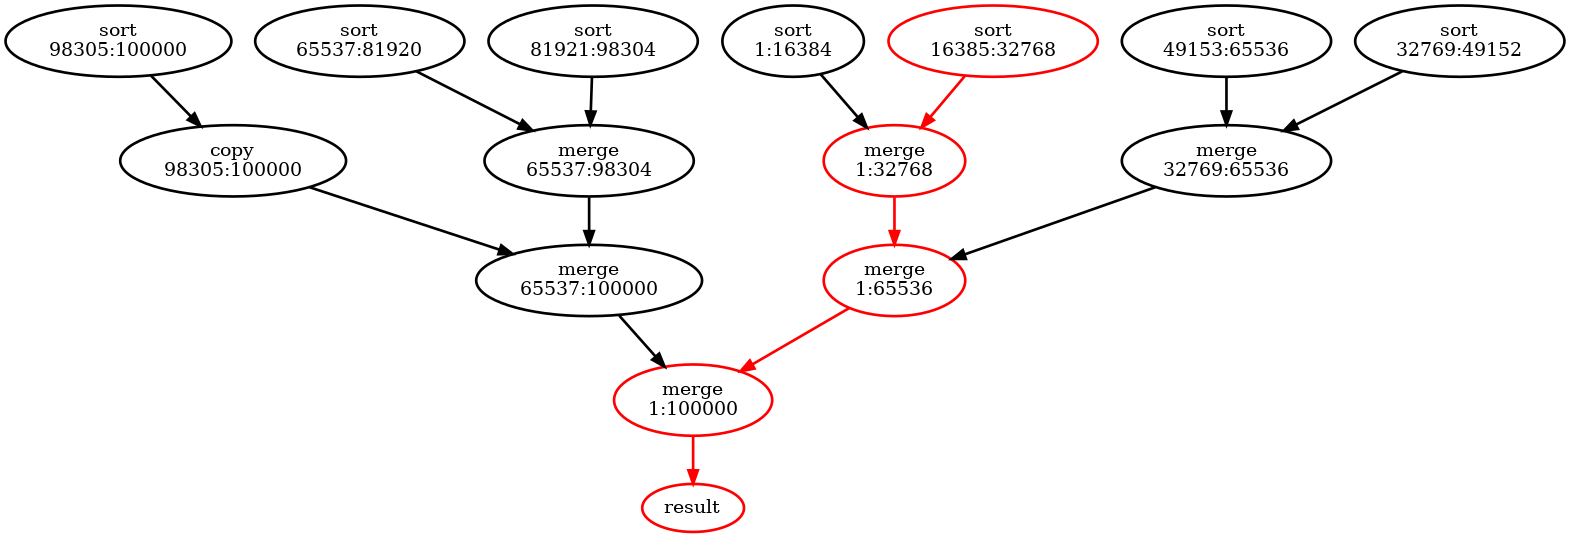

In [7]:
resize!(DataFlowTasks.get_active_taskgraph(), 2000)
log_info = DataFlowTasks.@log mergesort_dft!(copy(v))

using GraphViz
dag = GraphViz.Graph(log_info)

## Performance

In [8]:
N = 1_000_000
v = rand(N);
buf = similar(v);

using BenchmarkTools
@benchmark mergesort!(x, $buf) setup=(x=copy(v)) evals=1

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  130.499 ms … 132.650 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     130.826 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   131.064 ms ± 692.737 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ██    █ █ █     █      █                                    █  
  ██▁▁▁▁█▁█▁█▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  130 ms           Histogram: frequency by time          133 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [9]:
@benchmark mergesort_dft!(x, $buf) setup=(x=copy(v)) evals=1

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  38.735 ms … 50.339 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     41.118 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   42.862 ms ±  3.534 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▁  ▁  █▁▁▁█▁  ▁      ▁  ▁  ▁             ▁▁    █         ▁  
  ██▁▁█▁▁██████▁▁█▁▁▁▁▁▁█▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁█▁▁▁▁▁▁▁▁▁█ ▁
  38.7 ms         Histogram: frequency by time        50.3 ms <

 Memory estimate: 7.97 MiB, allocs estimate: 5633.

In [10]:
log_info = DataFlowTasks.@log mergesort_dft!(copy(v))
DataFlowTasks.describe(log_info, categories=["sort", "merge", "copy", "result"])

• Elapsed time           : 0.041
  ├─ Critical path       : 0.022
  ╰─ No-wait             : 0.028

• Run time               : 0.329
  ├─ Computing           :   0.226
  │  ├─ sort             :     0.167
  │  ├─ merge            :     0.059
  │  ├─ copy             :     0.000
  │  ├─ result           :     0.000
  │  ╰─ unlabeled        :     0.000
  ├─ Task insertion      :   0.000
  ╰─ Other (waiting)     :   0.103

[ Info: Computing    : 0.22586248000000003
[ Info: Inserting    : 0.00042447499999999995
[ Info: Other        : 0.10275922174648738


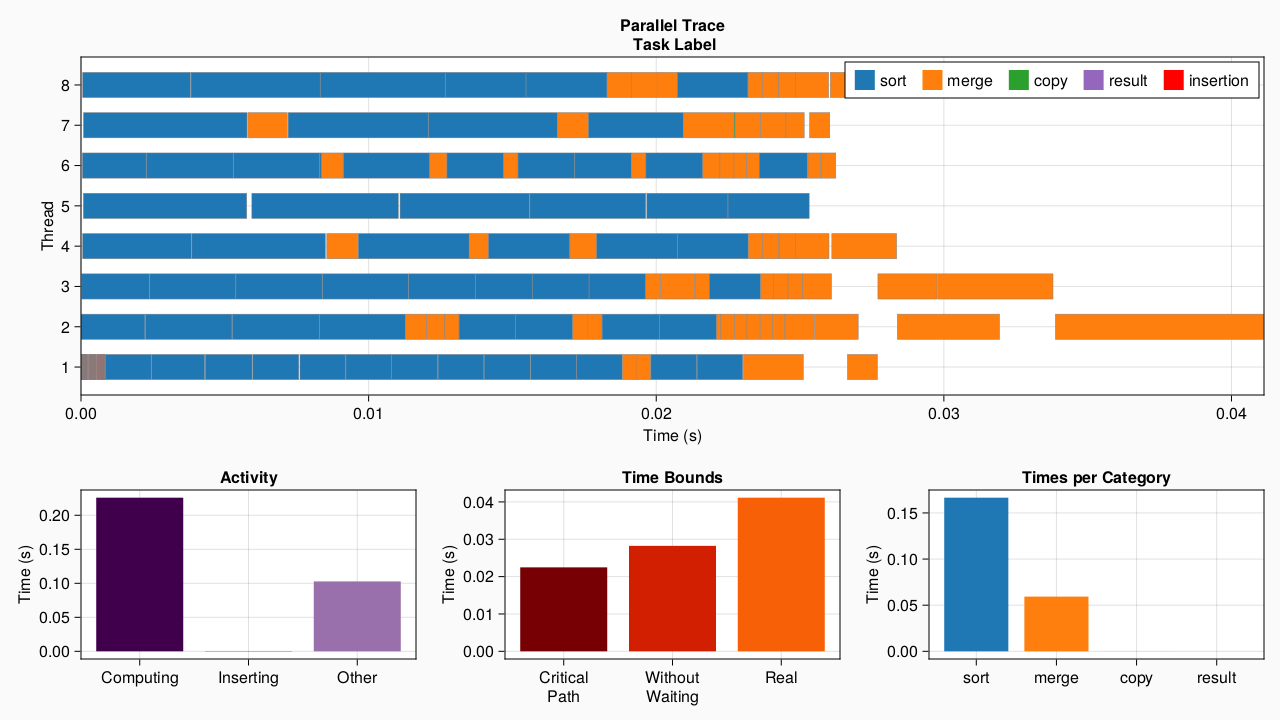

In [11]:
using CairoMakie
plot(log_info, categories=["sort", "merge", "copy", "result"])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*